In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import pickle
import os
import math
from collections import defaultdict, Counter
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from datetime import datetime

# ============================================================================
# HYPERPARAMETERS
# ============================================================================
class Config:
    # Data parameters
    train_file = 'train.csv'
    val_file = 'validation.csv'
    test_file = 'test.csv'

    # BPE Tokenizer parameters
    vocab_size = 50000
    tokenizer_file = 'bpe_tokenizer_all.pkl'

    # Model parameters (INCREASED DEPTH)
    d_model = 512
    n_heads = 8
    n_encoder_layers = 8  # INCREASED from 4 to 8 (2x deeper)
    n_decoder_layers = 8  # INCREASED from 4 to 8 (2x deeper)
    d_ff = 2048
    dropout = 0.1
    max_seq_len = 512
    max_summary_len = 64

    # Training parameters (adjusted for deeper network)
    batch_size = 24  # Slightly reduced due to increased memory from deeper model
    learning_rate = 0.0005  # Reduced for more stable training with deeper network
    n_epochs = 37
    warmup_steps = 4000  # Increased warmup for deeper network
    gradient_clip = 0.5  # Tighter clipping for deeper network stability
    label_smoothing = 0.1
    gradient_accumulation_steps = 2  # Increased to maintain effective batch size

    # Data sampling for faster training
    max_train_samples = 250
    max_val_samples = 100
    max_test_samples = 100

    # Generation parameters
    beam_size = 5
    length_penalty = 0.6
    top_k_summaries = 5
    max_generation_batches = 100

    # Model saving
    model_file = 'transformer_summarization_deep.pt'
    vocab_file = 'vocabulary.pkl'

    # Device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Performance optimizations
    num_workers = 0
    pin_memory = True if torch.cuda.is_available() else False
    compile_model = False
    use_flash_attention = False

    # Progress settings
    log_interval = 50
    validate_every_n_epochs = 1

config = Config()






In [5]:
# ============================================================================
# BPE TOKENIZER FROM SCRATCH (OPTIMIZED)
# ============================================================================
class BPETokenizer:
    def __init__(self, vocab_size=50000):
        self.vocab_size = vocab_size
        self.word_freqs = {}
        self.splits = {}
        self.merges = {}
        self.vocab = {}
        self.special_tokens = {
            '<PAD>': 0,
            '<UNK>': 1,
            '<SOS>': 2,
            '<EOS>': 3
        }

    def train(self, texts, progress=True, max_samples=1000000):
        """Train BPE tokenizer on texts"""
        print("Training BPE tokenizer (optimized)...")

        # Sample texts if too many
        if len(texts) > max_samples:
            print(f"Sampling {max_samples} texts from {len(texts)} for faster training...")
            import random
            texts = random.sample(texts, max_samples)

        # Count word frequencies (optimized with batch processing)
        print("Computing word frequencies...")
        word_counter = Counter()
        for text in tqdm(texts, disable=not progress):
            words = self._pre_tokenize(text)
            word_counter.update(words)

        # Keep only top words for efficiency
        max_words = 50000
        if len(word_counter) > max_words:
            print(f"Keeping top {max_words} most frequent words...")
            self.word_freqs = dict(word_counter.most_common(max_words))
        else:
            self.word_freqs = dict(word_counter)

        # Initialize splits (character level)
        print("Initializing character-level splits...")
        alphabet = set()
        for word in self.word_freqs.keys():
            alphabet.update(word)

        # Build initial vocabulary with special tokens
        self.vocab = self.special_tokens.copy()
        for char in sorted(alphabet):
            self.vocab[char] = len(self.vocab)

        # Initialize splits with tuples for immutability (faster)
        self.splits = {word: tuple(word) for word in self.word_freqs.keys()}

        # Learn merges
        num_merges = self.vocab_size - len(self.vocab)
        print(f"Learning {num_merges} merges...")

        # Cache pair positions for faster updates
        self.pair_cache = {}
        self._build_pair_cache()

        for i in tqdm(range(num_merges), disable=not progress):
            # Get most frequent pair from cache
            pair_freqs = self._compute_pair_freqs_cached()
            if not pair_freqs:
                break

            best_pair = max(pair_freqs, key=pair_freqs.get)
            merged = best_pair[0] + best_pair[1]
            self.merges[best_pair] = merged
            self.vocab[merged] = len(self.vocab)

            # Update splits efficiently (only words containing the pair)
            self._update_splits_cached(best_pair, merged)

        print(f"Vocabulary size: {len(self.vocab)}")

        # Clear cache to save memory
        self.pair_cache = None

    def _pre_tokenize(self, text):
        """Pre-tokenize text into words"""
        if not isinstance(text, str):
            text = str(text)
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s\.,!?;:\'\"-]', '', text)
        return text.split()

    def _build_pair_cache(self):
        """Build cache of which words contain which pairs"""
        self.pair_cache = defaultdict(set)
        for word in self.word_freqs.keys():
            split = self.splits[word]
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                self.pair_cache[pair].add(word)

    def _compute_pair_freqs_cached(self):
        """Compute frequency of character pairs using cache"""
        pair_freqs = defaultdict(int)
        for pair, words in self.pair_cache.items():
            for word in words:
                split = self.splits[word]
                # Count occurrences of pair in this split
                count = sum(1 for i in range(len(split) - 1)
                           if split[i] == pair[0] and split[i + 1] == pair[1])
                pair_freqs[pair] += count * self.word_freqs[word]
        return pair_freqs

    def _update_splits_cached(self, pair, merged):
        """Update splits only for words containing the pair"""
        words_to_update = self.pair_cache[pair].copy()

        # Remove old pair from cache
        del self.pair_cache[pair]

        for word in words_to_update:
            old_split = self.splits[word]
            new_split = []
            i = 0

            while i < len(old_split):
                if i < len(old_split) - 1 and old_split[i] == pair[0] and old_split[i + 1] == pair[1]:
                    new_split.append(merged)
                    i += 2
                else:
                    new_split.append(old_split[i])
                    i += 1

            self.splits[word] = tuple(new_split)

            # Update cache with new pairs
            for i in range(len(new_split) - 1):
                new_pair = (new_split[i], new_split[i + 1])
                self.pair_cache[new_pair].add(word)

    def _merge_pair(self, split, pair):
        """Merge a pair in a split"""
        new_split = []
        i = 0
        while i < len(split):
            if i < len(split) - 1 and split[i] == pair[0] and split[i + 1] == pair[1]:
                new_split.append(self.merges[pair])
                i += 2
            else:
                new_split.append(split[i])
                i += 1
        return new_split

    def tokenize(self, text):
        """Tokenize text using learned BPE (optimized)"""
        words = self._pre_tokenize(text)
        tokens = []

        # Create merge priority lookup (lower index = higher priority)
        merge_priority = {pair: idx for idx, pair in enumerate(self.merges.keys())}

        for word in words:
            # Get initial split
            split = list(word)

            # Apply merges efficiently
            while len(split) > 1:
                # Find all possible pairs
                pairs = [(i, (split[i], split[i + 1]))
                        for i in range(len(split) - 1)]

                # Filter to only valid merges and find highest priority
                valid_merges = [(i, pair) for i, pair in pairs if pair in merge_priority]

                if not valid_merges:
                    break

                # Get pair with highest priority (lowest index)
                min_pos, min_pair = min(valid_merges, key=lambda x: merge_priority[x[1]])

                # Merge the pair
                split = split[:min_pos] + [self.merges[min_pair]] + split[min_pos + 2:]

            tokens.extend(split)

        return tokens

    def encode(self, text, add_special_tokens=True):
        """Encode text to token IDs"""
        tokens = self.tokenize(text)
        ids = []

        if add_special_tokens:
            ids.append(self.special_tokens['<SOS>'])

        for token in tokens:
            ids.append(self.vocab.get(token, self.special_tokens['<UNK>']))

        if add_special_tokens:
            ids.append(self.special_tokens['<EOS>'])

        return ids

    def decode(self, ids, skip_special_tokens=True):
        """Decode token IDs to text"""
        id_to_token = {v: k for k, v in self.vocab.items()}
        tokens = []

        for id in ids:
            token = id_to_token.get(id, '<UNK>')
            if skip_special_tokens and token in self.special_tokens:
                continue
            tokens.append(token)

        # Join tokens with spaces for readability
        return ' '.join(tokens)

    def save(self, filepath):
        """Save tokenizer"""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'vocab_size': self.vocab_size,
                'word_freqs': self.word_freqs,
                'splits': self.splits,
                'merges': self.merges,
                'vocab': self.vocab,
                'special_tokens': self.special_tokens
            }, f)

    @classmethod
    def load(cls, filepath):
        """Load tokenizer"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)

        # Handle both old and new pickle formats
        tokenizer = cls(data.get('vocab_size', 10000))
        tokenizer.word_freqs = data.get('word_freqs', {})
        tokenizer.splits = data.get('splits', {})
        tokenizer.merges = data.get('merges', {})
        tokenizer.vocab = data.get('vocab', {})
        tokenizer.special_tokens = data.get('special_tokens', {
            '<PAD>': 0,
            '<UNK>': 1,
            '<SOS>': 2,
            '<EOS>': 3
        })

        return tokenizer


In [6]:
# ============================================================================
# SUMMARIZER
# ============================================================================
class SummarizationDataset(Dataset):
    def __init__(self, df, tokenizer, max_article_len, max_summary_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_article_len = max_article_len
        self.max_summary_len = max_summary_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        article = str(self.df.iloc[idx]['article'])
        summary = str(self.df.iloc[idx]['highlights'])

        # Encode
        article_ids = self.tokenizer.encode(article, add_special_tokens=True)
        summary_ids = self.tokenizer.encode(summary, add_special_tokens=True)

        # Truncate
        article_ids = article_ids[:self.max_article_len]
        summary_ids = summary_ids[:self.max_summary_len]

        return {
            'article': torch.tensor(article_ids, dtype=torch.long),
            'summary': torch.tensor(summary_ids, dtype=torch.long)
        }

def collate_fn(batch):
    """Collate function with padding"""
    articles = [item['article'] for item in batch]
    summaries = [item['summary'] for item in batch]

    # Pad sequences
    article_lens = [len(a) for a in articles]
    summary_lens = [len(s) for s in summaries]

    max_article_len = max(article_lens)
    max_summary_len = max(summary_lens)

    padded_articles = torch.zeros(len(batch), max_article_len, dtype=torch.long)
    padded_summaries = torch.zeros(len(batch), max_summary_len, dtype=torch.long)

    for i, (article, summary) in enumerate(zip(articles, summaries)):
        padded_articles[i, :len(article)] = article
        padded_summaries[i, :len(summary)] = summary

    return {
        'article': padded_articles,
        'summary': padded_summaries,
        'article_mask': (padded_articles != 0).unsqueeze(1).unsqueeze(2),
        'summary_mask': (padded_summaries != 0).unsqueeze(1).unsqueeze(2)
    }

In [7]:
# ============================================================================
# TRANSFORMER INTERNALS
# ============================================================================

# ============================================================================
# POSITIONAL ENCODING
# ============================================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ============================================================================
# MULTI-HEAD ATTENTION
# ============================================================================
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear projections
        Q = self.W_q(query).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)

        # Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            # Use -1e4 instead of -1e9 to avoid float16 overflow
            scores = scores.masked_fill(mask == 0, -1e4)

        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)

        # Apply attention to values
        x = torch.matmul(attention, V)

        # Concatenate heads
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Final linear projection
        x = self.W_o(x)

        return x

# ============================================================================
# FEED FORWARD NETWORK
# ============================================================================
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

# ============================================================================
# ENCODER LAYER (with Pre-LN for better deep network training)
# ============================================================================
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Pre-LN: Layer norm before attention (better for deep networks)
        normed = self.norm1(x)
        attn_output = self.self_attn(normed, normed, normed, mask)
        x = x + self.dropout(attn_output)

        # Pre-LN: Layer norm before feed-forward
        normed = self.norm2(x)
        ff_output = self.feed_forward(normed)
        x = x + self.dropout(ff_output)

        return x

# ============================================================================
# DECODER LAYER (with Pre-LN for better deep network training)
# ============================================================================
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        # Pre-LN: Layer norm before self-attention
        normed = self.norm1(x)
        attn_output = self.self_attn(normed, normed, normed, tgt_mask)
        x = x + self.dropout(attn_output)

        # Pre-LN: Layer norm before cross-attention
        normed = self.norm2(x)
        attn_output = self.cross_attn(normed, encoder_output, encoder_output, src_mask)
        x = x + self.dropout(attn_output)

        # Pre-LN: Layer norm before feed-forward
        normed = self.norm3(x)
        ff_output = self.feed_forward(normed)
        x = x + self.dropout(ff_output)

        return x



In [8]:
# ============================================================================
# TRANSFORMER MODEL (with final layer norms for Pre-LN architecture)
# ============================================================================
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_encoder_layers,
                 n_decoder_layers, d_ff, max_seq_len, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.encoder_embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_encoder_layers)
        ])

        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_decoder_layers)
        ])

        # Final layer norms for Pre-LN architecture
        self.encoder_norm = nn.LayerNorm(d_model)
        self.decoder_norm = nn.LayerNorm(d_model)

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        """Xavier initialization with adjusted scaling for deeper networks"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p, gain=1.0)

    def encode(self, src, src_mask):
        x = self.encoder_embedding(src) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.encoder_layers:
            x = layer(x, src_mask)

        # Final layer norm for Pre-LN architecture
        x = self.encoder_norm(x)
        return x

    def decode(self, tgt, encoder_output, src_mask, tgt_mask):
        x = self.decoder_embedding(tgt) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.decoder_layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)

        # Final layer norm for Pre-LN architecture
        x = self.decoder_norm(x)
        return x

    def forward(self, src, tgt, src_mask, tgt_mask):
        encoder_output = self.encode(src, src_mask)
        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        output = self.fc_out(decoder_output)
        return output

In [9]:
# ============================================================================
# BEAM SEARCH
# ============================================================================
class BeamSearch:
    def __init__(self, model, tokenizer, beam_size=4, max_len=128, length_penalty=0.6):
        self.model = model
        self.tokenizer = tokenizer
        self.beam_size = beam_size
        self.max_len = max_len
        self.length_penalty = length_penalty
        self.sos_id = tokenizer.special_tokens['<SOS>']
        self.eos_id = tokenizer.special_tokens['<EOS>']
        self.pad_id = tokenizer.special_tokens['<PAD>']

    def generate(self, src, src_mask):
        """Generate summary using beam search"""
        self.model.eval()
        batch_size = src.size(0)
        device = src.device

        # Encode source
        encoder_output = self.model.encode(src, src_mask)

        # Initialize beams: (batch_size, beam_size, seq_len)
        beams = torch.full((batch_size, self.beam_size, 1), self.sos_id, dtype=torch.long, device=device)
        beam_scores = torch.zeros(batch_size, self.beam_size, device=device)
        beam_scores[:, 1:] = -1e9  # Only first beam is active initially

        completed_beams = [[] for _ in range(batch_size)]

        for step in range(self.max_len - 1):
            # Prepare decoder input
            tgt = beams.view(batch_size * self.beam_size, -1)

            # Create target mask
            tgt_len = tgt.size(1)
            tgt_mask = torch.tril(torch.ones(tgt_len, tgt_len, device=device)).unsqueeze(0).unsqueeze(0)

            # Expand encoder output for beam search
            encoder_output_expanded = encoder_output.unsqueeze(1).repeat(1, self.beam_size, 1, 1)
            encoder_output_expanded = encoder_output_expanded.view(batch_size * self.beam_size, -1, self.model.d_model)

            src_mask_expanded = src_mask.unsqueeze(1).repeat(1, self.beam_size, 1, 1, 1)
            src_mask_expanded = src_mask_expanded.view(batch_size * self.beam_size, 1, 1, -1)

            # Decode
            with torch.no_grad():
                decoder_output = self.model.decode(tgt, encoder_output_expanded, src_mask_expanded, tgt_mask)
                logits = self.model.fc_out(decoder_output[:, -1, :])
                log_probs = F.log_softmax(logits, dim=-1)

            # Reshape log probs
            log_probs = log_probs.view(batch_size, self.beam_size, -1)

            # Calculate scores
            vocab_size = log_probs.size(-1)
            scores = beam_scores.unsqueeze(-1) + log_probs
            scores = scores.view(batch_size, -1)

            # Get top k scores and indices
            top_scores, top_indices = torch.topk(scores, self.beam_size, dim=-1)

            # Calculate which beam and which token
            beam_indices = top_indices // vocab_size
            token_indices = top_indices % vocab_size

            # Update beams - maintain structure per batch
            new_beams_by_batch = [[] for _ in range(batch_size)]
            new_scores_by_batch = [[] for _ in range(batch_size)]

            for b in range(batch_size):
                for i in range(self.beam_size):
                    beam_idx = beam_indices[b, i]
                    token_idx = token_indices[b, i]

                    # Get previous beam
                    prev_beam = beams[b, beam_idx]

                    # Check if EOS
                    if token_idx == self.eos_id:
                        # Apply length penalty
                        score = top_scores[b, i] / ((prev_beam.size(0) + 1) ** self.length_penalty)
                        completed_beams[b].append((prev_beam.tolist() + [token_idx.item()], score.item()))
                        # Add a dummy beam to maintain beam_size count
                        new_beams_by_batch[b].append(prev_beam)  # Keep the previous beam
                        new_scores_by_batch[b].append(torch.tensor(-1e9, device=device))  # Very low score
                    else:
                        new_beam = torch.cat([prev_beam, token_idx.unsqueeze(0)])
                        new_beams_by_batch[b].append(new_beam)
                        new_scores_by_batch[b].append(top_scores[b, i])

            # Check if all beams are completed
            if all(len(completed_beams[b]) >= self.beam_size for b in range(batch_size)):
                break

            # Convert to tensor (pad if necessary)
            max_len = max(max(beam.size(0) for beam in batch_beams) for batch_beams in new_beams_by_batch)
            
            all_beams = []
            all_scores = []
            
            for b in range(batch_size):
                batch_beams = []
                for beam in new_beams_by_batch[b]:
                    if beam.size(0) < max_len:
                        padding = torch.full((max_len - beam.size(0),), self.pad_id, dtype=torch.long, device=device)
                        beam = torch.cat([beam, padding])
                    batch_beams.append(beam)
                all_beams.append(torch.stack(batch_beams))
                all_scores.append(torch.stack(new_scores_by_batch[b]))

            beams = torch.stack(all_beams)
            beam_scores = torch.stack(all_scores)

        # Get best beam for each batch
        results = []
        for b in range(batch_size):
            if completed_beams[b]:
                best_beam = max(completed_beams[b], key=lambda x: x[1])[0]
            else:
                best_beam = beams[b, 0].tolist()
            results.append(best_beam)

        return results


In [10]:
# ============================================================================
# BLEU SCORE FROM SCRATCH
# ============================================================================
class BLEUScore:
    def __init__(self, max_n=4):
        self.max_n = max_n

    def _get_ngrams(self, tokens, n):
        """Get n-grams from tokens"""
        ngrams = []
        for i in range(len(tokens) - n + 1):
            ngrams.append(tuple(tokens[i:i+n]))
        return ngrams

    def _modified_precision(self, reference, hypothesis, n):
        """Calculate modified n-gram precision"""
        ref_ngrams = Counter(self._get_ngrams(reference, n))
        hyp_ngrams = Counter(self._get_ngrams(hypothesis, n))

        if not hyp_ngrams:
            return 0.0

        clipped_counts = {}
        for ngram in hyp_ngrams:
            clipped_counts[ngram] = min(hyp_ngrams[ngram], ref_ngrams.get(ngram, 0))

        numerator = sum(clipped_counts.values())
        denominator = sum(hyp_ngrams.values())

        return numerator / denominator if denominator > 0 else 0.0

    def _brevity_penalty(self, reference, hypothesis):
        """Calculate brevity penalty"""
        ref_len = len(reference)
        hyp_len = len(hypothesis)

        if hyp_len > ref_len:
            return 1.0
        elif hyp_len == 0:
            return 0.0
        else:
            return math.exp(1 - ref_len / hyp_len)

    def compute(self, references, hypotheses):
        """
        Compute BLEU score
        references: list of reference token lists
        hypotheses: list of hypothesis token lists
        """
        assert len(references) == len(hypotheses)

        precisions = [[] for _ in range(self.max_n)]
        total_ref_len = 0
        total_hyp_len = 0

        for ref, hyp in zip(references, hypotheses):
            total_ref_len += len(ref)
            total_hyp_len += len(hyp)

            for n in range(1, self.max_n + 1):
                prec = self._modified_precision(ref, hyp, n)
                precisions[n-1].append(prec)

        # Average precisions
        avg_precisions = [sum(p) / len(p) if p else 0.0 for p in precisions]

        # Geometric mean of precisions
        if min(avg_precisions) > 0:
            geo_mean = math.exp(sum(math.log(p) for p in avg_precisions) / self.max_n)
        else:
            geo_mean = 0.0

        # Brevity penalty
        if total_hyp_len > total_ref_len:
            bp = 1.0
        elif total_hyp_len == 0:
            bp = 0.0
        else:
            bp = math.exp(1 - total_ref_len / total_hyp_len)

        bleu = bp * geo_mean

        return {
            'bleu': bleu,
            'precisions': avg_precisions,
            'brevity_penalty': bp,
            'length_ratio': total_hyp_len / total_ref_len if total_ref_len > 0 else 0.0
        }


In [11]:
# ============================================================================
# TRAINING
# ============================================================================
def create_masks(src, tgt, pad_id=0):
    """Create masks for source and target"""
    # Source mask (batch_size, 1, 1, src_len)
    src_mask = (src != pad_id).unsqueeze(1).unsqueeze(2)

    # Target mask (causal) - convert to bool first
    tgt_len = tgt.size(1)
    tgt_mask = torch.tril(torch.ones(tgt_len, tgt_len, device=tgt.device, dtype=torch.bool)).unsqueeze(0).unsqueeze(0)
    tgt_pad_mask = (tgt != pad_id).unsqueeze(1).unsqueeze(2)
    tgt_mask = tgt_mask & tgt_pad_mask

    return src_mask, tgt_mask

def train_epoch(model, dataloader, optimizer, criterion, device, config, scaler=None):
    """Train for one epoch with mixed precision and gradient accumulation"""
    model.train()
    total_loss = 0
    optimizer.zero_grad(set_to_none=True)

    pbar = tqdm(dataloader, desc='Training', dynamic_ncols=True)
    for batch_idx, batch in enumerate(pbar):
        src = batch['article'].to(device, non_blocking=True)
        tgt = batch['summary'].to(device, non_blocking=True)

        # Create masks
        src_mask, tgt_mask = create_masks(src, tgt[:, :-1])

        # Mixed precision training
        if scaler is not None:
            with torch.cuda.amp.autocast():
                output = model(src, tgt[:, :-1], src_mask, tgt_mask)
                output = output.reshape(-1, output.size(-1))
                tgt_out = tgt[:, 1:].reshape(-1)
                loss = criterion(output, tgt_out) / config.gradient_accumulation_steps

            scaler.scale(loss).backward()

            if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        else:
            output = model(src, tgt[:, :-1], src_mask, tgt_mask)
            output = output.reshape(-1, output.size(-1))
            tgt_out = tgt[:, 1:].reshape(-1)
            loss = criterion(output, tgt_out) / config.gradient_accumulation_steps

            loss.backward()

            if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item() * config.gradient_accumulation_steps

        # Update progress bar less frequently
        if batch_idx % config.log_interval == 0:
            pbar.set_postfix({
                'loss': f'{loss.item() * config.gradient_accumulation_steps:.4f}',
                'avg': f'{total_loss/(batch_idx+1):.4f}'
            }, refresh=False)

    return total_loss / len(dataloader)


In [12]:
def validate(model, dataloader, criterion, device, config, tokenizer=None, compute_bleu=False):
    """Validate model (faster version) with optional BLEU computation"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    # For BLEU computation
    references = []
    hypotheses = []
    max_bleu_batches = 20  # Compute BLEU on subset for speed

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validating', dynamic_ncols=True)
        for batch_idx, batch in enumerate(pbar):
            src = batch['article'].to(device, non_blocking=True)
            tgt = batch['summary'].to(device, non_blocking=True)

            # Create masks
            src_mask, tgt_mask = create_masks(src, tgt[:, :-1])

            # Forward pass with mixed precision
            if config.device == 'cuda':
                with torch.cuda.amp.autocast():
                    output = model(src, tgt[:, :-1], src_mask, tgt_mask)
                    output = output.reshape(-1, output.size(-1))
                    tgt_out = tgt[:, 1:].reshape(-1)
                    loss = criterion(output, tgt_out)
            else:
                output = model(src, tgt[:, :-1], src_mask, tgt_mask)
                output = output.reshape(-1, output.size(-1))
                tgt_out = tgt[:, 1:].reshape(-1)
                loss = criterion(output, tgt_out)

            total_loss += loss.item()
            num_batches += 1
            
            # Compute BLEU on subset
            if compute_bleu and tokenizer and batch_idx < max_bleu_batches:
                # Simple greedy decoding for BLEU (faster than beam search)
                predictions = output.argmax(dim=-1).view(src.size(0), -1)
                
                for i in range(src.size(0)):
                    # Reference
                    ref_ids = tgt[i].cpu().tolist()
                    ref_ids = [id for id in ref_ids if id not in [
                        tokenizer.special_tokens['<PAD>'],
                        tokenizer.special_tokens['<SOS>'],
                        tokenizer.special_tokens['<EOS>']
                    ]]
                    references.append(ref_ids)
                    
                    # Hypothesis
                    hyp_ids = predictions[i].cpu().tolist()
                    hyp_ids = [id for id in hyp_ids if id not in [
                        tokenizer.special_tokens['<PAD>'],
                        tokenizer.special_tokens['<SOS>'],
                        tokenizer.special_tokens['<EOS>']
                    ]]
                    hypotheses.append(hyp_ids)
    
    avg_loss = total_loss / num_batches
    
    # Compute BLEU if requested
    bleu_score = None
    if compute_bleu and tokenizer and references:
        bleu_scorer = BLEUScore()
        bleu_results = bleu_scorer.compute(references, hypotheses)
        bleu_score = bleu_results['bleu']
    
    return avg_loss, bleu_score

In [13]:
# ============================================================================
# VISUALIZATION
# ============================================================================
def plot_training_curves(train_losses, val_losses, val_bleu_scores, save_path='training_curves.png'):
    """
    Plot training and validation curves
    
    Args:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch (with None for non-validation epochs)
        val_bleu_scores: List of BLEU scores per epoch (with None for non-validation epochs)
        save_path: Path to save the plot
    """
    # Filter out None values for validation metrics
    val_epochs = [i for i, loss in enumerate(val_losses) if loss is not None]
    val_losses_filtered = [loss for loss in val_losses if loss is not None]
    val_bleu_filtered = [bleu for bleu in val_bleu_scores if bleu is not None]
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Training Loss
    axes[0].plot(range(len(train_losses)), train_losses, 'b-', linewidth=2, label='Training Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Plot 2: Training vs Validation Loss
    axes[1].plot(range(len(train_losses)), train_losses, 'b-', linewidth=2, label='Training Loss', alpha=0.7)
    if val_losses_filtered:
        axes[1].plot(val_epochs, val_losses_filtered, 'r-', linewidth=2, marker='o', 
                     markersize=6, label='Validation Loss')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Plot 3: BLEU Score
    if val_bleu_filtered:
        axes[2].plot(val_epochs, val_bleu_filtered, 'g-', linewidth=2, marker='s', 
                     markersize=6, label='Validation BLEU')
        axes[2].set_xlabel('Epoch', fontsize=12)
        axes[2].set_ylabel('BLEU Score', fontsize=12)
        axes[2].set_title('BLEU Score over Epochs', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()
        
        # Add best BLEU annotation
        if val_bleu_filtered:
            best_bleu = max(val_bleu_filtered)
            best_epoch = val_epochs[val_bleu_filtered.index(best_bleu)]
            axes[2].axhline(y=best_bleu, color='r', linestyle='--', alpha=0.5, linewidth=1)
            axes[2].text(0.02, 0.98, f'Best BLEU: {best_bleu:.4f} (Epoch {best_epoch+1})', 
                        transform=axes[2].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        axes[2].text(0.5, 0.5, 'No BLEU scores available', 
                    ha='center', va='center', transform=axes[2].transAxes, fontsize=14)
        axes[2].set_title('BLEU Score over Epochs', fontsize=14, fontweight='bold')
    
    # Add overall statistics
    fig.suptitle(f'Training Progress - {len(train_losses)} Epochs', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    # Add timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    fig.text(0.99, 0.01, f'Generated: {timestamp}', ha='right', fontsize=8, alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Training curves saved to {save_path}")
    
    # Also display if in notebook
    try:
        from IPython.display import display
        plt.show()
    except:
        pass
    
    plt.close()

In [14]:
# ============================================================================
# CHECKPOINT LOADING AND SAVING
# ============================================================================
def save_checkpoint(epoch, model, optimizer, scheduler, scaler, val_loss, train_losses, val_losses, val_bleu_scores, config):
    """Save training checkpoint with atomic write to prevent corruption"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'scaler_state_dict': scaler.state_dict() if scaler else None,
        'val_loss': val_loss,
        'train_losses': train_losses,  # Save loss history
        'val_losses': val_losses,      # Save validation loss history
        'val_bleu_scores': val_bleu_scores,  # Save BLEU score history
        'config': {
            'n_encoder_layers': config.n_encoder_layers,
            'n_decoder_layers': config.n_decoder_layers,
            'd_model': config.d_model,
            'n_heads': config.n_heads,
            'd_ff': config.d_ff,
            'vocab_size': config.vocab_size,
            'max_seq_len': config.max_seq_len,
            'dropout': config.dropout
        }
    }
    
    # Atomic save: write to temp file first, then rename
    temp_file = config.model_file + '.tmp'
    try:
        torch.save(checkpoint, temp_file)
        # Rename is atomic on most systems
        if os.path.exists(config.model_file):
            os.replace(temp_file, config.model_file)
        else:
            os.rename(temp_file, config.model_file)
        print(f"✓ Checkpoint saved to {config.model_file}")
    except Exception as e:
        print(f"✗ Error saving checkpoint: {e}")
        if os.path.exists(temp_file):
            os.remove(temp_file)

def load_checkpoint(model, optimizer, scheduler, scaler, config):
    """Load training checkpoint if it exists"""
    if not os.path.exists(config.model_file):
        print("No checkpoint found. Starting training from scratch.")
        return 0, float('inf'), [], [], []
    
    print(f"Loading checkpoint from {config.model_file}...")
    
    try:
        # Load checkpoint with weights_only=False since we have optimizer/scheduler state
        checkpoint = torch.load(config.model_file, map_location=config.device, weights_only=False)
        
        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])
        print("✓ Model state loaded")
        
        # Load optimizer state
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("✓ Optimizer state loaded")
        
        # Load scheduler state if available
        if scheduler and checkpoint.get('scheduler_state_dict'):
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print("✓ Scheduler state loaded")
        
        # Load scaler state if available
        if scaler and checkpoint.get('scaler_state_dict'):
            scaler.load_state_dict(checkpoint['scaler_state_dict'])
            print("✓ Scaler state loaded")
        
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint.get('val_loss', float('inf'))
        
        # Load loss histories (with defaults for backward compatibility)
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_bleu_scores = checkpoint.get('val_bleu_scores', [])
        
        print(f"✓ Resuming from epoch {start_epoch}")
        print(f"✓ Best validation loss: {best_val_loss:.4f}")
        print(f"✓ Loaded {len(train_losses)} training loss records")
        
        return start_epoch, best_val_loss, train_losses, val_losses, val_bleu_scores
        
    except (RuntimeError, EOFError, pickle.UnpicklingError, Exception) as e:
        print(f"✗ Error loading checkpoint: {e}")
        print("✗ Checkpoint file appears to be corrupted.")
        
        # Create backup of corrupted file
        backup_file = config.model_file + '.corrupted'
        print(f"Creating backup at: {backup_file}")
        try:
            os.rename(config.model_file, backup_file)
            print("✓ Corrupted checkpoint backed up.")
        except:
            print("✗ Could not backup corrupted file. Deleting it.")
            os.remove(config.model_file)
        
        print("Starting training from scratch.")
        return 0, float('inf'), [], [], []

In [15]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================
def main():
    print("=" * 80)
    print("DEEPER TRANSFORMER TEXT SUMMARIZATION (WITH RESUME CAPABILITY)")
    print("=" * 80)
    print(f"Device: {config.device}")
    print(f"Model Depth: {config.n_encoder_layers} encoder layers, {config.n_decoder_layers} decoder layers")
    print()

    # Load or train tokenizer
    print("Step 1: Loading/Training Tokenizer")
    print("-" * 80)

    tokenizer = None
    if os.path.exists(config.tokenizer_file):
        try:
            print(f"Loading tokenizer from {config.tokenizer_file}")
            tokenizer = BPETokenizer.load(config.tokenizer_file)
            print("Tokenizer loaded successfully!")
        except (KeyError, EOFError, pickle.UnpicklingError) as e:
            print(f"Error loading tokenizer: {e}")
            print("Deleting corrupted tokenizer file and training new one...")
            os.remove(config.tokenizer_file)
            tokenizer = None

    if tokenizer is None:
        print("Training new tokenizer...")
        # Load training data
        train_df = pd.read_csv(config.train_file)

        # Combine articles and summaries for tokenizer training
        texts = train_df['article'].tolist() + train_df['highlights'].tolist()

        tokenizer = BPETokenizer(vocab_size=config.vocab_size)
        tokenizer.train(texts)
        tokenizer.save(config.tokenizer_file)
        print(f"Tokenizer saved to {config.tokenizer_file}")

    print(f"Vocabulary size: {len(tokenizer.vocab)}")
    
    # Save vocabulary immediately
    print("Saving vocabulary...")
    with open(config.vocab_file, 'wb') as f:
        pickle.dump(tokenizer.vocab, f)
    print(f"✓ Vocabulary saved to {config.vocab_file}")
    print()

    # Load datasets
    print("Step 2: Loading Datasets")
    print("-" * 80)

    train_df = pd.read_csv(config.train_file)
    val_df = pd.read_csv(config.val_file)
    test_df = pd.read_csv(config.test_file)

    # Sample datasets for faster training
    if len(train_df) > config.max_train_samples:
        print(f"Sampling {config.max_train_samples} from {len(train_df)} training samples...")
        train_df = train_df.sample(n=config.max_train_samples, random_state=42)

    if len(val_df) > config.max_val_samples:
        print(f"Sampling {config.max_val_samples} from {len(val_df)} validation samples...")
        val_df = val_df.sample(n=config.max_val_samples, random_state=42)

    if len(test_df) > config.max_test_samples:
        print(f"Sampling {config.max_test_samples} from {len(test_df)} test samples...")
        test_df = test_df.sample(n=config.max_test_samples, random_state=42)

    print(f"Train samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    print()

    # Create datasets
    train_dataset = SummarizationDataset(train_df, tokenizer, config.max_seq_len, config.max_summary_len)
    val_dataset = SummarizationDataset(val_df, tokenizer, config.max_seq_len, config.max_summary_len)
    test_dataset = SummarizationDataset(test_df, tokenizer, config.max_seq_len, config.max_summary_len)

    # Create dataloaders with optimizations
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=True if config.num_workers > 0 else False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=True if config.num_workers > 0 else False
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=True if config.num_workers > 0 else False
    )

    # Create model
    print("Step 3: Creating Model")
    print("-" * 80)

    model = Transformer(
        vocab_size=len(tokenizer.vocab),
        d_model=config.d_model,
        n_heads=config.n_heads,
        n_encoder_layers=config.n_encoder_layers,
        n_decoder_layers=config.n_decoder_layers,
        d_ff=config.d_ff,
        max_seq_len=config.max_seq_len,
        dropout=config.dropout
    ).to(config.device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Architecture: {config.n_encoder_layers}×Encoder + {config.n_decoder_layers}×Decoder")

    # Compile model for PyTorch 2.0+ (significant speedup)
    if config.compile_model and hasattr(torch, 'compile'):
        print("Compiling model with torch.compile()...")
        try:
            model = torch.compile(model, mode='reduce-overhead')
            print("Model compiled successfully!")
        except Exception as e:
            print(f"Could not compile model: {e}")

    print()

    # Training setup with label smoothing
    criterion = nn.CrossEntropyLoss(
        ignore_index=tokenizer.special_tokens['<PAD>'],
        label_smoothing=config.label_smoothing
    )
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        betas=(0.9, 0.98),
        eps=1e-9,
        weight_decay=0.01,
        fused=True if config.device == 'cuda' else False
    )

    # Learning rate scheduler for better convergence with deeper network
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config.learning_rate,
        epochs=config.n_epochs,
        steps_per_epoch=len(train_loader) // config.gradient_accumulation_steps,
        pct_start=0.1
    )

    # Mixed precision training scaler
    if config.device == 'cuda':
        try:
            # Try new API (PyTorch 2.0+)
            scaler = torch.amp.GradScaler('cuda')
        except (AttributeError, TypeError):
            # Fall back to old API
            scaler = torch.cuda.amp.GradScaler()
    else:
        scaler = None

    # Load checkpoint if exists
    print("Step 4: Checking for Existing Checkpoint")
    print("-" * 80)
    start_epoch, best_val_loss, train_losses, val_losses, val_bleu_scores = load_checkpoint(
        model, optimizer, scheduler, scaler, config
    )
    print()

    # Training loop
    print("Step 5: Training the Network")
    print("-" * 80)
    print(f"Total epochs: {config.n_epochs}")
    print(f"Starting from epoch: {start_epoch + 1}")
    print(f"Total batches per epoch: {len(train_loader)}")
    print(f"Effective batch size: {config.batch_size * config.gradient_accumulation_steps}")
    print()

    for epoch in range(start_epoch, config.n_epochs):
        print(f"\nEpoch {epoch + 1}/{config.n_epochs}")
        epoch_start_time = torch.cuda.Event(enable_timing=True) if config.device == 'cuda' else None
        epoch_end_time = torch.cuda.Event(enable_timing=True) if config.device == 'cuda' else None

        if epoch_start_time:
            epoch_start_time.record()

        train_loss = train_epoch(model, train_loader, optimizer, criterion, config.device, config, scaler)
        train_losses.append(train_loss)  # Track training loss

        if epoch_end_time:
            epoch_end_time.record()
            torch.cuda.synchronize()
            elapsed_time = epoch_start_time.elapsed_time(epoch_end_time) / 1000.0
            print(f"Epoch time: {elapsed_time:.2f}s")

        # Validate only every N epochs
        if (epoch + 1) % config.validate_every_n_epochs == 0:
            val_loss, bleu_score = validate(model, val_loader, criterion, config.device, config, 
                                           tokenizer=tokenizer, compute_bleu=True)
            
            val_losses.append(val_loss)  # Track validation loss
            val_bleu_scores.append(bleu_score)  # Track BLEU score
            
            if bleu_score is not None:
                print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | BLEU: {bleu_score:.4f}")
            else:
                print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_checkpoint(epoch, model, optimizer, scheduler, scaler, val_loss, 
                              train_losses, val_losses, val_bleu_scores, config)
        else:
            val_losses.append(None)  # No validation this epoch
            val_bleu_scores.append(None)  # No BLEU this epoch
            print(f"Train Loss: {train_loss:.4f}")

    print()
    print("Training completed!")
    print()

    # Plot training curves
    print("Step 6: Plotting Training Curves")
    print("-" * 80)
    plot_training_curves(train_losses, val_losses, val_bleu_scores, save_path='training_curves.png')
    print()

    # Load best model
    checkpoint = torch.load(config.model_file, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Evaluation with BLEU
    print("Step 7: Final Evaluation")
    print("-" * 80)

    beam_search = BeamSearch(model, tokenizer, beam_size=config.beam_size,
                            max_len=config.max_summary_len, length_penalty=config.length_penalty)
    bleu_scorer = BLEUScore()

    references = []
    hypotheses = []
    examples = []

    model.eval()
    batch_count = 0
    print(f"Generating summaries (max {config.max_generation_batches} batches)...")

    for i, batch in enumerate(tqdm(test_loader, desc='Generating summaries')):
        if batch_count >= config.max_generation_batches:
            break

        src = batch['article'].to(config.device)
        tgt = batch['summary'].to(config.device)
        src_mask, _ = create_masks(src, tgt)

        # Generate summaries
        with torch.no_grad():
            generated = beam_search.generate(src, src_mask)

        for j in range(len(generated)):
            # Reference
            ref_ids = tgt[j].cpu().tolist()
            ref_ids = [id for id in ref_ids if id not in [tokenizer.special_tokens['<PAD>'],
                                                           tokenizer.special_tokens['<SOS>'],
                                                           tokenizer.special_tokens['<EOS>']]]
            references.append(ref_ids)

            # Hypothesis
            hyp_ids = [id for id in generated[j] if id not in [tokenizer.special_tokens['<PAD>'],
                                                                tokenizer.special_tokens['<SOS>'],
                                                                tokenizer.special_tokens['<EOS>']]]
            hypotheses.append(hyp_ids)

            # Save examples
            if len(examples) < config.top_k_summaries:
                article_ids = src[j].cpu().tolist()
                article_ids = [id for id in article_ids if id not in [tokenizer.special_tokens['<PAD>']]]

                examples.append({
                    'article': tokenizer.decode(article_ids),
                    'reference': tokenizer.decode(ref_ids),
                    'generated': tokenizer.decode(hyp_ids)
                })

        batch_count += 1

    # Compute BLEU
    bleu_results = bleu_scorer.compute(references, hypotheses)

    print(f"\nBLEU Score: {bleu_results['bleu']:.4f}")
    print(f"Brevity Penalty: {bleu_results['brevity_penalty']:.4f}")
    print(f"Length Ratio: {bleu_results['length_ratio']:.4f}")
    for i, prec in enumerate(bleu_results['precisions'], 1):
        print(f"Precision-{i}: {prec:.4f}")
    print()

    # Display top examples
    print(f"Step 8: Top {config.top_k_summaries} Generated Summaries")
    print("=" * 80)

    for i, example in enumerate(examples, 1):
        print(f"\nExample {i}:")
        print("-" * 80)
        print(f"Article (truncated): {example['article'][:200]}...")
        print(f"\nReference Summary: {example['reference']}")
        print(f"\nGenerated Summary: {example['generated']}")
        print()

    print("=" * 80)
    print("DONE!")
    print("=" * 80)

DEEPER TRANSFORMER TEXT SUMMARIZATION (WITH RESUME CAPABILITY)
Device: cuda
Model Depth: 8 encoder layers, 8 decoder layers

Step 1: Loading/Training Tokenizer
--------------------------------------------------------------------------------
Loading tokenizer from bpe_tokenizer_all.pkl
Tokenizer loaded successfully!
Vocabulary size: 50000
Saving vocabulary...
✓ Vocabulary saved to vocabulary.pkl

Step 2: Loading Datasets
--------------------------------------------------------------------------------
Sampling 250 from 287113 training samples...
Sampling 100 from 13368 validation samples...
Sampling 100 from 11490 test samples...
Train samples: 250
Validation samples: 100
Test samples: 100

Step 3: Creating Model
--------------------------------------------------------------------------------
Total parameters: 135,703,376
Trainable parameters: 135,703,376
Architecture: 8×Encoder + 8×Decoder

Step 4: Checking for Existing Checkpoint
--------------------------------------------------------

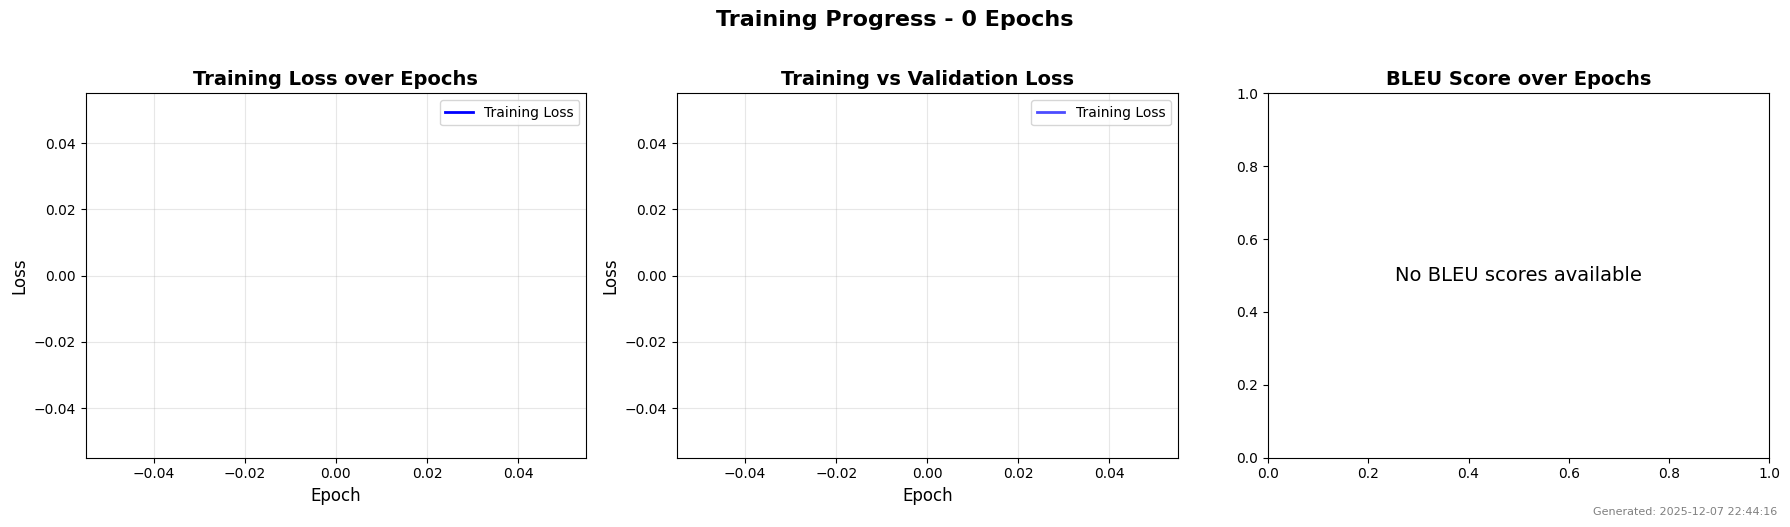


Step 7: Final Evaluation
--------------------------------------------------------------------------------
Generating summaries (max 100 batches)...


Generating summaries: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.46s/it]


BLEU Score: 0.0368
Brevity Penalty: 0.8009
Length Ratio: 0.8183
Precision-1: 0.3342
Precision-2: 0.0692
Precision-3: 0.0228
Precision-4: 0.0084

Step 8: Top 5 Generated Summaries

Example 1:
--------------------------------------------------------------------------------
Article (truncated): comedian jenny e clair travelled with her other half on a painting in venus break with flavours . there comes a time in a womans life when beach holidays just dont cut it any longer, when lying on gol...

Reference Summary: the comedian stayed with flavours who offer a painting in venice break . jenny and her partner ge of stayed at the farmhouse villa bianchi . days involved sitting in medieval market towns with a brush and prose c co .

Generated Summary: comic book artist jenny stone takes inspiration from all over the world . she takes inspiration from all over the world and the rest of the world . highlights include fine art and art of art and art .


Example 2:
------------------------------

In [16]:
    main()